In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
!curl -k -o helper_functions.py https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10246  100 10246    0     0  29616      0 --:--:-- --:--:-- --:--:-- 29784
100 10246  100 10246    0     0  29605      0 --:--:-- --:--:-- --:--:-- 29784


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    shuffle=True
)

test_data_10_precent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
for images, labels in train_data_10_percent.take(1): # `.take()` Takes the Number of batches that you mention EX. 1 in this case
  print(images, labels)

tf.Tensor(
[[[[202.05612     71.05612     17.056124  ]
   [202.78061     71.78061     17.780611  ]
   [195.26021     64.2602      10.260203  ]
   ...
   [ 51.15311     22.806135    12.086755  ]
   [ 56.709156    23.903017    13.3060875 ]
   [ 49.387592    12.030449     4.8672576 ]]

  [[197.78572     68.78572     13.785715  ]
   [202.65306     73.65306     18.653063  ]
   [202.15816     72.94388     18.586739  ]
   ...
   [ 37.50013     11.040882     2.127594  ]
   [ 46.076553    17.918388     6.99492   ]
   [ 51.377613    21.137815    11.209244  ]]

  [[193.86224     66.86224     11.862245  ]
   [196.90306     69.90306     14.903061  ]
   [198.44388     71.44387     18.872448  ]
   ...
   [ 27.239758     7.6683292    0.47448543]
   [ 28.341848     6.6122274    0.8265255 ]
   [ 28.198957     4.4132433    0.        ]]

  ...

  [[151.13268     68.42352     22.341904  ]
   [150.24487     63.612206    18.270409  ]
   [154.33672     64.403076    20.739845  ]
   ...
   [ 31.785736     6.785

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # (x) at the end refers to passing on to the next func
print(f"Shape after GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_precent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_precent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20241127-123010
Epoch 1/5
24/24 [==============================] - 11s 144ms/step - loss: 1.8618 - accuracy: 0.4533 - val_loss: 1.2762 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 2s 83ms/step - loss: 1.1349 - accuracy: 0.7307 - val_loss: 0.8433 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 2s 84ms/step - loss: 0.8290 - accuracy: 0.8240 - val_loss: 0.6818 - val_accuracy: 0.8586
Epoch 4/5
24/24 [==============================] - 2s 83ms/step - loss: 0.6907 - accuracy: 0.8413 - val_loss: 0.5860 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 2s 84ms/step - loss: 0.5844 - accuracy: 0.8720 - val_loss: 0.5260 - val_accuracy: 0.8849


In [11]:
model_0.evaluate(test_data_10_precent)

79/79 [==============================] - 4s 46ms/step - loss: 0.5631 - accuracy: 0.8576


[0.5630761981010437, 0.8575999736785889]

In [12]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


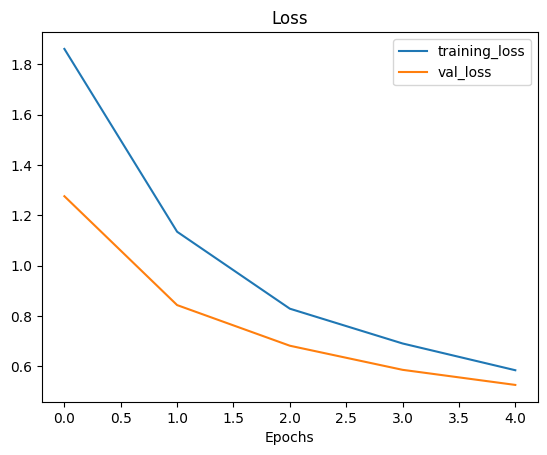

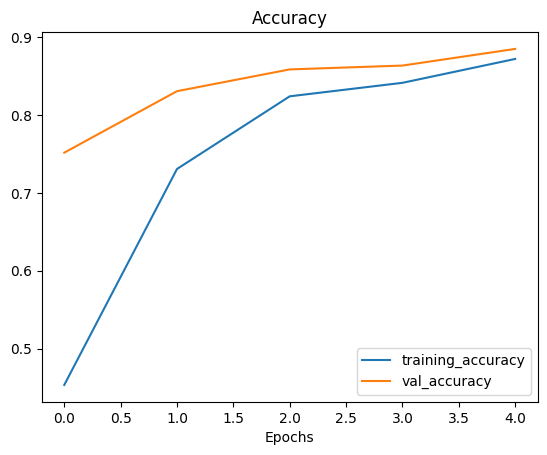

In [15]:
plot_loss_curves(history_10_percent)

- Shape after `base_model`: **(None, 7, 7, 1280)**
- After `GlobalAveragePooling2D()`: **(None, 1280)**

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [16]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [17]:
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [18]:
# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooling_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [19]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [20]:
!curl -k -o 10_food_classes_1_percent.zip https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  127M    0 83412    0     0  78138      0  0:28:29  0:00:01  0:28:28 78321
  1  127M    1 1662k    0     0   841k      0  0:02:35  0:00:01  0:02:34  841k
 14  127M   14 18.3M    0     0  6328k      0  0:00:20  0:00:02  0:00:18 6331k
 28  127M   28 35.7M    0     0  9038k      0  0:00:14  0:00:04  0:00:10 9043k
 42  127M   42 54.3M    0     0  10.8M      0  0:00:11  0:00:04  0:00:07 10.8M
 57  127M   57 73.6M    0     0  12.3M      0  0:00:10  0:00:05  0:00:05 14.9M
 71  127M   71 90.4M    0     0  12.9M      0  0:00:09  0:00:06  0:00:03 17.7M
 86  127M   86  110M    0     0  13.8M      0  0:00:09  0:00:07  0:00:02 18.3M
100  127M  100  127M    0     0  14.2M      0  0:00:08  0:00:08 --:--:-- 18.7M


In [21]:
unzip_data("10_food_classes_1_percent.zip")

In [22]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [23]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [24]:
img_size = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
                                                                            train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            batch_size=32,
                                                                            image_size=img_size
                                                                        )

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
                                                                            test_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            batch_size=32,
                                                                            image_size=img_size
                                                                        )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Awesome!

We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255), # keep for ResNet50V2, remove for EfficientNet
], name = "data_augmentation")

### **AIM** : To Visualize a random image befire and after *augmentation* 

In [26]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

10_food_classes_1_percent/train/hamburger/840018.jpg


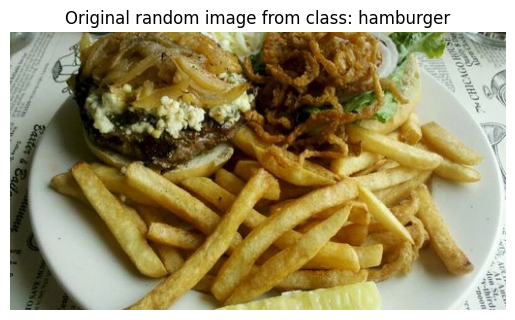

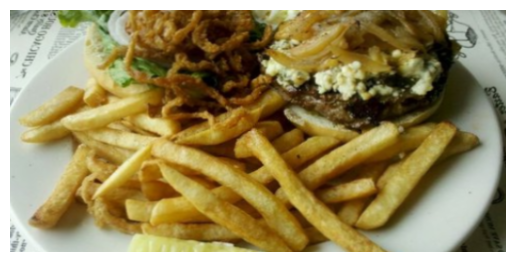

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

# This method returns the list of all files and directories in the specified path. The return type of this method is list.
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes
print(random_image_path)

augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img)
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [41]:
imput_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(inputs)

x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data_1_percent,
                    validation_steps=int(0.25* len(test_data_1_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20241127-123911
Epoch 1/5
3/3 [==============================] - 10s 1s/step - loss: 2.3669 - accuracy: 0.0571 - val_loss: 2.3181 - val_accuracy: 0.0938
Epoch 2/5
3/3 [==============================] - 1s 607ms/step - loss: 2.3153 - accuracy: 0.1143 - val_loss: 2.3155 - val_accuracy: 0.1184
Epoch 3/5
3/3 [==============================] - 2s 622ms/step - loss: 2.3306 - accuracy: 0.1000 - val_loss: 2.3164 - val_accuracy: 0.1003
Epoch 4/5
3/3 [==============================] - 2s 666ms/step - loss: 2.3438 - accuracy: 0.1286 - val_loss: 2.3138 - val_accuracy: 0.1069
Epoch 5/5
3/3 [==============================] - 2s 725ms/step - loss: 2.3307 - accuracy: 0.1143 - val_loss: 2.3240 - val_accuracy: 0.1020


In [42]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [43]:
model_1.evaluate(test_data_1_percent)

79/79 [==============================] - 4s 43ms/step - loss: 2.3195 - accuracy: 0.1000


[2.319514513015747, 0.10000000149011612]

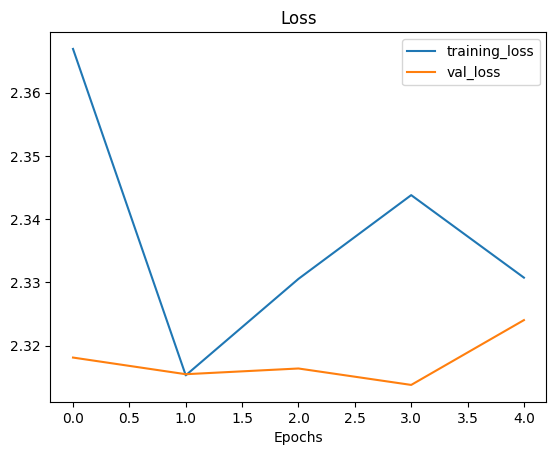

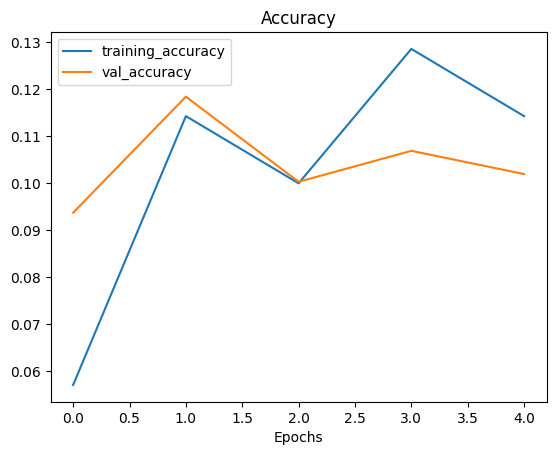

In [44]:
plot_loss_curves(history_1_percent)

In [45]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [46]:
img_size = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode = "categorical",
    image_size = img_size
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    label_mode = "categorical",
    image_size = img_size
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [47]:
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [48]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_aug = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(1/255),
], name = "data_aug")

In [50]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_layer = layers.Input(shape = input_shape, name = "input_layer")

x = data_aug(input_layer)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name = "ouput_layer")(x)

model_2 = tf.keras.Model(input_layer, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_2_percent = model_2.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=int(0.25* len(test_data_10_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241127-124542
Epoch 1/5
24/24 [==============================] - 18s 361ms/step - loss: 2.3591 - accuracy: 0.0973 - val_loss: 2.3749 - val_accuracy: 0.0921
Epoch 2/5
24/24 [==============================] - 6s 251ms/step - loss: 2.3472 - accuracy: 0.0840 - val_loss: 2.3207 - val_accuracy: 0.0938
Epoch 3/5
24/24 [==============================] - 5s 209ms/step - loss: 2.3420 - accuracy: 0.0960 - val_loss: 2.3542 - val_accuracy: 0.0724
Epoch 4/5
24/24 [==============================] - 5s 208ms/step - loss: 2.3361 - accuracy: 0.1080 - val_loss: 2.3249 - val_accuracy: 0.0888
Epoch 5/5
24/24 [==============================] - 6s 233ms/step - loss: 2.3481 - accuracy: 0.0800 - val_loss: 2.3119 - val_accuracy: 0.1053


### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [52]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [53]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [55]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data_10_percent,
                                          validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241127-124730
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9581 - accuracy: 0.3680
Epoch 1: val_loss improved from inf to 1.43145, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 17s 357ms/step - loss: 1.9581 - accuracy: 0.3680 - val_loss: 1.4315 - val_accuracy: 0.6678
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.6773
Epoch 2: val_loss improved from 1.43145 to 1.02785, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 6s 248ms/step - loss: 1.3666 - accuracy: 0.6773 - val_loss: 1.0278 - val_accuracy: 0.7878
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0893 - accuracy: 0.7267
Epoch 3: val_loss improved from 1.02785 to 0.81212, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==

In [57]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 4s 49ms/step - loss: 0.6513 - accuracy: 0.8316


[0.6512654423713684, 0.83160001039505]

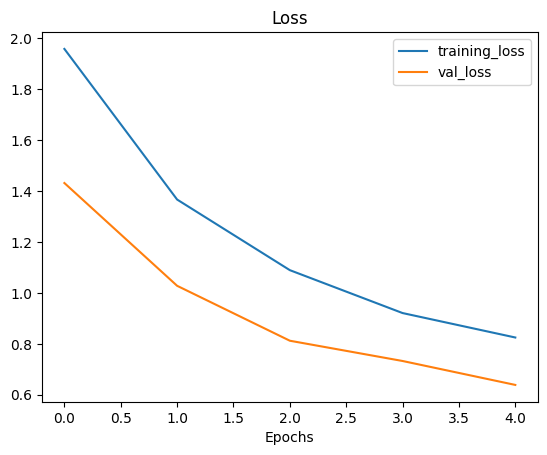

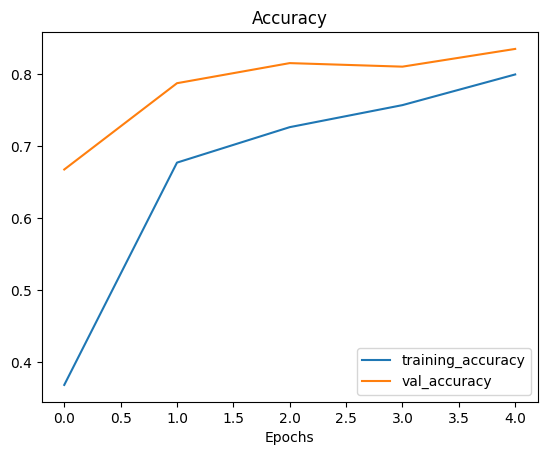

In [58]:
plot_loss_curves(history_10_percent_data_aug)